# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第2章：2期間モデルと数値計算の概観

## 2.5 一階条件を使う：求根アルゴリズム
### 2.5.1 非線形方程式のゼロ点を探す

### パラメータの設定はこれまでとまったく同じ

In [1]:
struct Models
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度
    
    # 要素価格
    rent::Float64 #純利子率
    
    # グリッド
    nw::Int64 #所得グリッドの数
    w_max::Float64 #所得グリッドの最大値
    w_min::Float64 #所得グリッドの最小値
    grid_w::Vector{Float64} #所得グリッド
end

In [2]:
function Calibration()
    # パラメータはここで設定をする
    β = 0.985^30
    γ = 2.0
    rent = 1.025^30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = collect(LinRange(w_min, w_max, nw))

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)
end

Calibration (generic function with 1 method)

## 経済学でよく使う関数を設定しておく

In [4]:
function mu_CRRA(cons, γ)
    return cons^(-γ)
end

mu_CRRA (generic function with 1 method)

---

In [5]:
# Root Finding用のライブラリを読み込む
using Plots
pyplot()
using Roots # ここが新しいところ：前回はOptimだった

In [6]:
# パラメータを設定
params = Calibration()

Models(0.6354580927313491, 2.0, 1.0975675790817858, 10, 1.0, 0.1, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8999999999999999, 1.0])

---

## ゼロ点を探す関数を作成
* 残差関数(residual function)
* テキストの(2.8)式

In [7]:
"""
2期間モデルの1階条件の残差を求める

# インプット
`a::Real`: 貯蓄水準
`w_val::Real`: 所得水準
`m::Models`: パラメータを含む構造体

# アウトプット
残差
"""
function resid_two_period(a, w_val, params)

    # オイラー方程式の左辺：若年期の限界効用
    if w_val - a > 0.0
        mu1 = mu_CRRA(w_val-a, params.γ)
    else
        mu1 = 10000.0
    end

    # 老年期の限界効用
    mu2 = mu_CRRA((1.0 + params.rent)*a, params.γ)

    # 残差(residual)
    return params.β*(1.0 + params.rent)*(mu2/mu1) - 1.0

end

resid_two_period

# 実際にゼロ点を探す

In [8]:
# 空っぽの変数を用意：policy functionの器
a_nl = zeros(params.nw)

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [9]:
# 実際に各w_{i}のもとで、残差関数がゼロになるようなaを探す
for (w_ind, w_val) in enumerate(params.grid_w)

    # 1変数のfunctionにする
    resid_two_period!(a) = resid_two_period(a, w_val, params)

    # 0.01はゼロ点を探す際の初期値
    a_nl[w_ind] = find_zero(resid_two_period!, 0.01)

end

print(a_nl)

[0.035500887771154545, 0.0710017755423091, 0.10650266331346364, 0.14200355108461818, 0.17750443885577274, 0.21300532662692728, 0.24850621439808182, 0.2840071021692364, 0.31950798994039087, 0.35500887771154543]

### ⬆のプロセスと一つの関数にまとめておく

In [10]:
"""
ゼロ点探索によって2期間モデルを解く

# インプット
`m::Models`:パラメータを含む構造体

# アウトプット
`a_nl::Vector`:政策関数
"""
function Root_find(params::Models)
    a_nl = zeros(params.nw)

    for (w_ind, w_val) in enumerate(params.grid_w)
        resid_two_period!(a) = resid_two_period(a, w_val, params)
        a_nl[w_ind] = find_zero(resid_two_period!, 0.01)
    end
    return a_nl
end

Root_find

In [11]:
# 関数の実行
@time a_nl = Root_find(params) # 実行時間の計測

  0.000048 seconds (11 allocations: 1.703 KiB)


10-element Vector{Float64}:
 0.035500887771154545
 0.0710017755423091
 0.10650266331346364
 0.14200355108461818
 0.17750443885577274
 0.21300532662692728
 0.24850621439808182
 0.2840071021692364
 0.31950798994039087
 0.35500887771154543

---

## 結果を出力

In [12]:
# 解析解
# テキストの(2.4)式
coef1 = (params.β*(1.0+params.rent))^(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*params.grid_w;

---

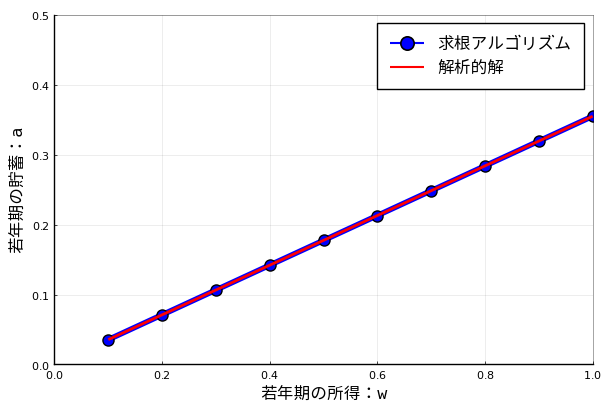

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/TomoakiYamada/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [13]:
plt = plot(params.grid_w, a_nl,
    color = :blue,
    marker = :circle,
    legend = :topright,
    xlims = (0, 1.0),
    ylims = (0, 0.5),
    label = ("求根アルゴリズム"),
    xlabel = ("若年期の所得：w"),
    ylabel = ("若年期の貯蓄：a"),
    linewidth = 4,
    markersize = 8,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.grid_w, a_cfs, linewidth = 2, color = :red, label="解析的解")
savefig("Fig2_pol_root_finding.pdf")

---

### 残差をプロットしてみる：図2.3

In [15]:
"""
本文中の残差についての図を書くための関数
"""
function resid_ex(params::Models)

    na = 40
    a_max = 1.0
    a_min = 0.025
    grid_a = collect(LinRange(a_min, a_max, na))

    resid = zeros(na, 3)
    grid_zero = zeros(na)

    wlist = [0.5, 0.8, 1.0]
    for (w_ind, w_val) in enumerate(wlist)
        resid_two_period!(a) = resid_two_period(a, w_val, params)
        for j in 1:na
            resid[j, w_ind] = resid_two_period!(grid_a[j])
        end
    end
    return resid, grid_zero
end

resid_ex

In [16]:
resid, grid_zero = resid_ex(params)

([108.36494907898863 290.1349475482218 459.7869461195062; 23.538949793346486 67.16374942596245 108.36494907898863; … ; -0.9999681314927076 -0.9999681314927076 -0.9998008218294223; -0.9999697050002552 -0.9999697050002552 -0.9999697050002552], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [17]:
na = 40
a_max = 1.0
a_min = 0.025
grid_a = collect(LinRange(a_min, a_max, na));

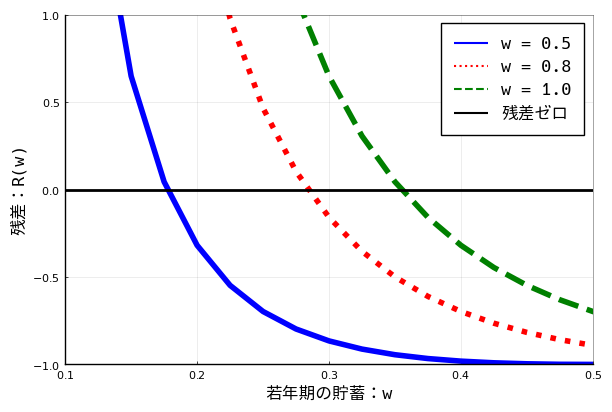

In [18]:
plt = plot(grid_a, resid[:, 1],
    color = :blue,
    linestyle = :solid,
    legend = :topright,
    xlims = (0.1, 0.5),
    ylims = (-1.0, 1.0),
    label = ("w = 0.5"),
    xlabel = ("若年期の貯蓄：w"),
    ylabel = ("残差：R(w)"),
    linewidth = 4,
#    markersize = 8,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(grid_a, resid[:, 2], linestyle = :dot, linewidth = 4, color = :red, label="w = 0.8")
plot!(grid_a, resid[:, 3], linestyle = :dash, linewidth = 4, color = :green, label="w = 1.0")
plot!(grid_a, grid_zero, linewidth = 2, color = :black, label="残差ゼロ")
savefig("Fig2_residual.pdf")

---

## エクササイズ
* 最適化を用いたアルゴリズムから導出した政策関数の精度を確認してみよう。